## 🚀 Project LineageImpact
*Data lineage offers a detailed map of how data flows. It describes data sources, transformations, and relationships. It is critical for data governance and compliance. By knowing every data hop, you can ensure quality and traceability.*

### 🌐 NetworkX for Data Lineage
- **Model Lineage**: NetworkX represents data sources as a directed graph. This makes it easy to visualize data movement.
- **Centrality Analysis**: Detect critical data assets. High in-degree nodes signal key data consumers.
- **Community Detection**: Identify data silos. Nodes in the same community share similar data flows.
- **Path Analysis**: Find the shortest path between data sources and sinks. This helps in debugging and optimization.
- **Graph Algorithms**: Use NetworkX algorithms to analyze data lineage. For example, PageRank can identify influential data assets.

### With a fully constructed lineage graph, organizations can:
1. **Detect data sources and destinations** 🏭 by analyzing incoming and outgoing connections.
2. **Spot data transformations** 🔧 through impact analysis—trace transformations and the nodes they affect.
3. **Identify quality issues** ❗ by filtering problematic data paths with incomplete or inconsistent transformations.
4. **Find the most relevant data lineage paths** ➡️ through graph traversal, quickly revealing how data moves from start to finish.
5. **Optimize costs** 💰 by discovering unused or redundant datasets (orphan nodes) and removing them.
6. **Implement automation** 🤖 in monitoring data lineage changes to maintain up-to-date visuals and insights.


More info, [17 Super Valuable Automated Data Lineage Use Cases With Examples](https://www.montecarlodata.com/blog-automated-data-lineage-use-cases/)

## Dataset 📊✨🚀
Because real data lineage datasets are often scarce and confidential, we’ll use a **synthetic** one to showcase data lineage analysis. To make this happen, we wrote a script that creates a **NetworkX** graph 🌐 with carefully crafted nodes and edges.

### Steps to Create the Dataset ⚙️🛠️
1. **Number of Nodes & Edges** ➡️ Decide how large the graph should be.  
2. **Generate Nodes**: Each node has
   - 🆔 **Node ID**  
   - 🏷️ **name**  
   - 🏷️ **type** (e.g. Table, Column)  
   - 🏷️ **data_source** (e.g. Snowflake, Redshift)  
   - 🏷️ **team** (e.g. team1, team2)  
3. **Generate Edges**: Connect nodes to represent lineage paths 🔗.  
4. **Build the Graph**: Use **NetworkX** to create your data lineage graph.

### Considerations 🤔💡
1. **Orphan Nodes**: Some are left unconnected to illustrate orphaned assets.  
2. **Hard-Coded Relationships**: Types like `transformed_by`, `consumed_by`, `produced_by` add realism 🔥.  
3. **Type Restrictions**: Only certain assets (e.g. tables) can link via certain relationships.  
4. **Data Source Constraints**:  
   - 🏢 **Snowflake**: Tables, columns, etc.  
   - 📊 **Tableau**: Dashboards, etc.  
5. **Limited Teams**: e.g. `team1`, `team2`, `team3`, …, `teamN`.
6. Kept subgraphs which are disconnected from the main graph.

### Data Lineage Constraints in Short
- **Teams & Data Sources**: Each team claims assets on certain platforms (e.g. Snowflake, BigQuery) .  
- **Valid Asset Types**: Tools have unique asset constraints (dbt → transformations, BI → dashboards/reports) .  
- **Relationship Types**: Tables → columns may be parent-child; flows can be `depends_on`, `produces`, `references`.  
- **Column-Level Lineage**: Granular column-to-column connections show transformations like aggregates and filters .  
- **Job Relationships**: Tools like Airflow consume or produce tables, views, and topics .  
- **Streaming & Storage**: Kafka topics & S3 buckets link to other assets via `populates`, `consumes`, `produces` .  
- **BI Tools**: Dashboards and reports ingest tables, views, or models in classic BI flows .  

### Example Data Lineage Graph 📊🚀
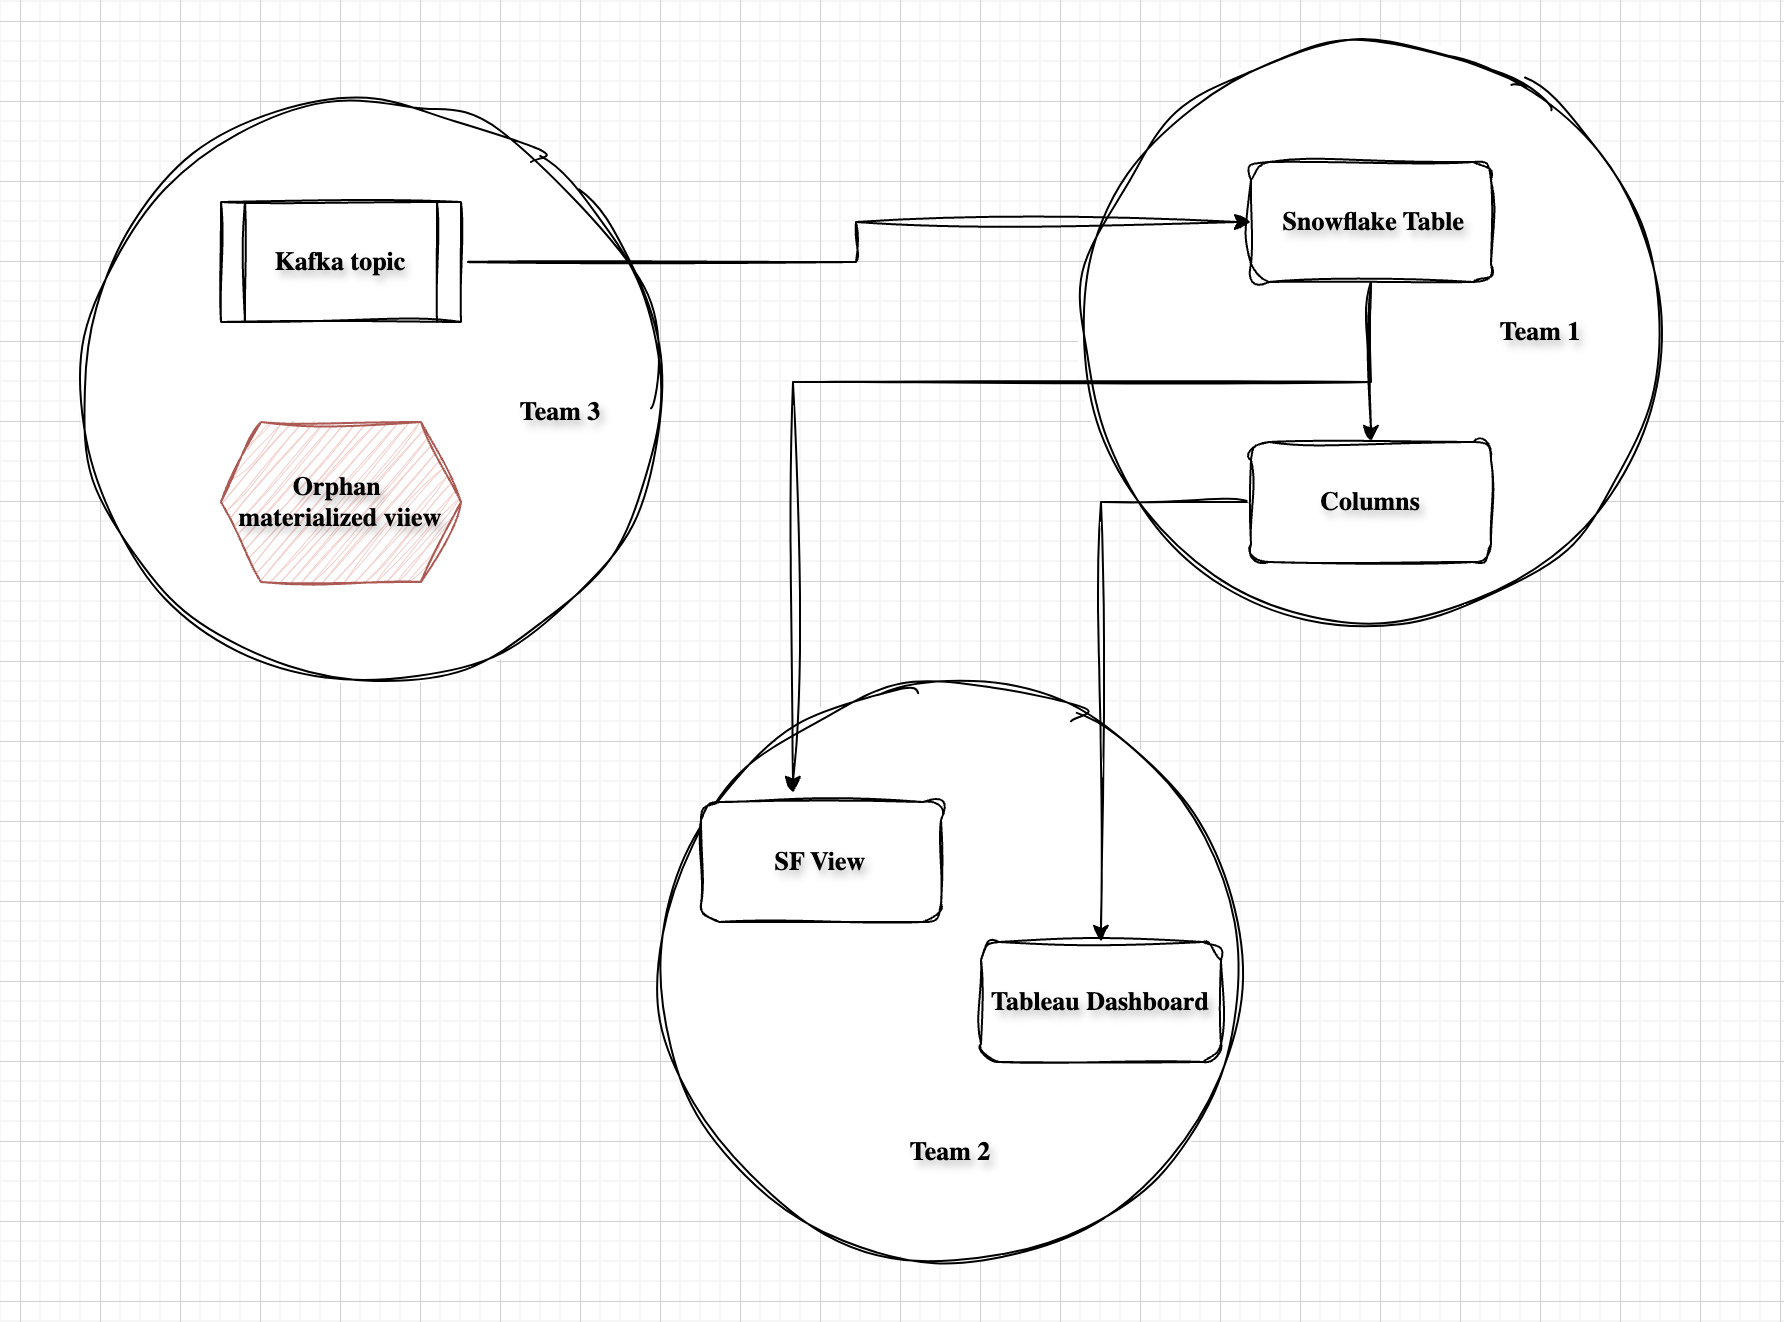

*Logic to generate this graph is available in the file `lineage_generator.py`. And run the script `generate_lineage.py` to create the network graph with the asked format. *

In [ ]:
%env NX_CURGAPH_AUTOCONFIG=True

In [ ]:
!pip install "jupyter>=1.1.1" \
            "langchain>=0.3.20" \
            "langchain-community>=0.3.19" \
            "langchain-openai>=0.3.7" \
            "langgraph>=0.3.5" \
            "matplotlib>=3.10.1" \
            "nx-arangodb>=1.3.0" \
            "pandas>=2.2.3" \
            "scipy>=1.15.2" \
            "openai>=1.65.3" \
            "langsmith>=0.3.11" \
            "langchain-core>=0.3.41" \
            "gradio>=5.3.0" \
            "tabulate>=0.9.0" \
            "plotly>=6.0.0" \
            "langchain-anthropic>=0.3.9"

In [15]:
import re
import gradio as gr
import pandas as pd

import nx_arangodb as nxadb
import networkx as nx
from typing import List
from arango import ArangoClient

from langgraph.graph import START, StateGraph
from langgraph.checkpoint.memory import MemorySaver
from langchain_openai import ChatOpenAI
from langchain_anthropic import ChatAnthropic
from langchain_community.graphs import ArangoGraph
from langchain_core.tools import tool
from langchain.prompts import PromptTemplate
from langchain_core.output_parsers import StrOutputParser
from langchain.chains import LLMChain

from typing_extensions import TypedDict
from pydantic import BaseModel
from typing import Optional
from typing import List
import plotly.express as px

In [ ]:
import os

os.environ["LANGSMITH_TRACING"] = "true"
os.environ["LANGSMITH_ENDPOINT"] = "https://api.smith.langchain.com"
os.environ["LANGSMITH_PROJECT"] = "pr-impassioned-disengagement-60"
os.environ["LANGSMITH_API_KEY"] = ""
os.environ["OPENAI_API_KEY"] = ""
os.environ["ANTHROPIC_API_KEY"] = ""

In [17]:
import os
import json
import time
from lineage_generator import LineageGraphGenerator

def main():
    
    nodes = 50000
    edge_multiplier = 15
    teams = 6
    output_dir = "output"
    graph_formats = "gexf"
    
    print(f"Generating lineage graph with minimum {nodes} nodes across {teams} teams")
    print(f"Expected edge count: {nodes * edge_multiplier}")
    
    # Time the graph generation
    start_time = time.time()
    
    # Create the generator
    generator = LineageGraphGenerator(
        min_nodes=nodes,
        edge_multiplier=edge_multiplier,
        num_teams=teams,
        output_dir=output_dir
    )
    
    # Generate the graph
    generator.generate_graph()
    
    # Get graph statistics
    stats = generator.get_graph_stats()
    
    # Save graph in requested formats
    formats = graph_formats.split(",")
    filenames = []
    
    print("g",formats)
    for fmt in formats:
        fmt = fmt.strip().lower()
        if fmt in ['json', 'gexf', 'graphml']:
            filename = generator.save_graph(format=fmt)
            filenames.append(filename)
            print(f"Saved {fmt} graph to {filename}")
    
    # Save statistics
    stats_file = os.path.join(output_dir, "graph_stats.json")
    with open(stats_file, 'w') as f:
        json.dump(stats, f, indent=2)
    
    end_time = time.time()
    elapsed = end_time - start_time
    
    print(f"\nGraph generation completed in {elapsed:.2f} seconds")
    print(f"Generated {stats['total_nodes']} nodes and {stats['total_edges']} edges")
    print(f"Statistics saved to {stats_file}")
    print(f"Graph files saved: {', '.join(filenames)}")

if __name__ == "__main__":
    main()


Generating lineage graph with minimum 50000 nodes across 6 teams
Expected edge count: 750000
Generating lineage graph with minimum 50000 nodes and approximately 750000 edges...
Generating nodes for Team 1...
Generating nodes for Team 2...
Generating nodes for Team 3...
Generating nodes for Team 4...
Generating nodes for Team 5...
Generating nodes for Team 6...
Only generated 7542 nodes. Adding 42458 more nodes...
Only generated 46758 edges. Adding 703242 more edges...
Creating orphaned nodes...
Created 5000 orphaned nodes
Creating disconnected subgraphs...
Created 3 disconnected subgraphs
Final graph has 50028 nodes and 607312 edges
Graph connectivity: 9020 connected components, 9016 orphaned nodes
g ['gexf']
Graph saved to output/lineage_graph_20250310_102317.gexf
Saved gexf graph to output/lineage_graph_20250310_102317.gexf

Graph generation completed in 195.80 seconds
Generated 50028 nodes and 607312 edges
Statistics saved to output/graph_stats.json
Graph files saved: output/lineage

### Load the graph into ArangoDB

In [22]:
G = nx.read_gexf("output/lineage_graph_20250310_102317.gexf")

In [ ]:
db = ArangoClient(hosts='https://fc01eecc8be0.arangodb.cloud:8529', request_timeout=240).db(username='root', password='', verify=True, name='datalineage')
arango_graph = ArangoGraph(db)

In [25]:
# load the graph into arangodb
G_adb = nxadb.Graph(
    name="asset",
    db=db,
    incoming_graph_data=G,
    overwrite_graph=True
)

[10:30:11 +0530] [INFO]: Overwriting graph 'asset'
[10:30:12 +0530] [INFO]: Graph 'asset' exists.
[10:30:13 +0530] [INFO]: Default node type set to 'asset'
[2025/03/10 10:30:14 +0530] [35654] [INFO] - adbnx_adapter: Instantiated ADBNX_Adapter with database 'datalineage'


Output()

Output()

[2025/03/10 10:30:35 +0530] [35654] [INFO] - adbnx_adapter: Created ArangoDB 'asset' Graph


### INstall cugraph backend for NetworkX

In [ ]:
# 3. Install nx-cugraph via pip
# Note: Only enable this installation if the step above is working!

!pip install nx-cugraph-cu12 --extra-index-url https://pypi.nvidia.com # Requires CUDA-capable GPU

### Form here actual analysis starts
1. Initialize networkX-ArangoDB connection
2. Load the graph from ArangoDB

### Fetch the DIgraph from ArangoDB

In [20]:
G_adb = nxadb.DiGraph(db=db, name='asset', overwrite_graph=False)
print(G_adb)

[10:25:47 +0530] [INFO]: Graph 'asset' exists.
[10:25:47 +0530] [INFO]: Default node type set to 'asset'


DiGraph named 'asset' with 129 nodes and 201 edges


In [ ]:
llm = ChatOpenAI(temperature=0, model_name="gpt-4o")
# llm  = ChatAnthropic(model_name="claude-3-5-sonnet-latest")

### AssetNode
Each node in the graph represents an asset in the data lineage. Asset is a type in data world, like column, table, dashboard, etc. Each asset has a unique id, name, type, data_source, and team. The team is the team that owns the asset. The data_source is the source of the asset, like Snowflake, Redshift, etc.

In [ ]:
class AssetNode(BaseModel):
    _key: str
    _id: str
    id: str
    name: str
    full_name: str
    type: str
    data_source: str
    team: str
    created_at: str
    score: int
    
    result: dict = {}
    
    @classmethod
    def from_node(cls, node_data):
        return cls(**node_data)
    
    @classmethod
    def from_aql_document(cls, doc):
        return cls(**doc)

In [ ]:
def get_graph_properties(G_adb, node_ids):
    nodes = []
    for node_id in node_ids:
        node = G_adb.nodes[node_id]
        nodes.append(AssetNode.from_node(node))
    return nodes

In [ ]:
graph_stats = ""
with open('output/graph2/graph_stats.json', 'r') as f:
    graph_stats = f.read()

### Now most of the agentic magic starts here
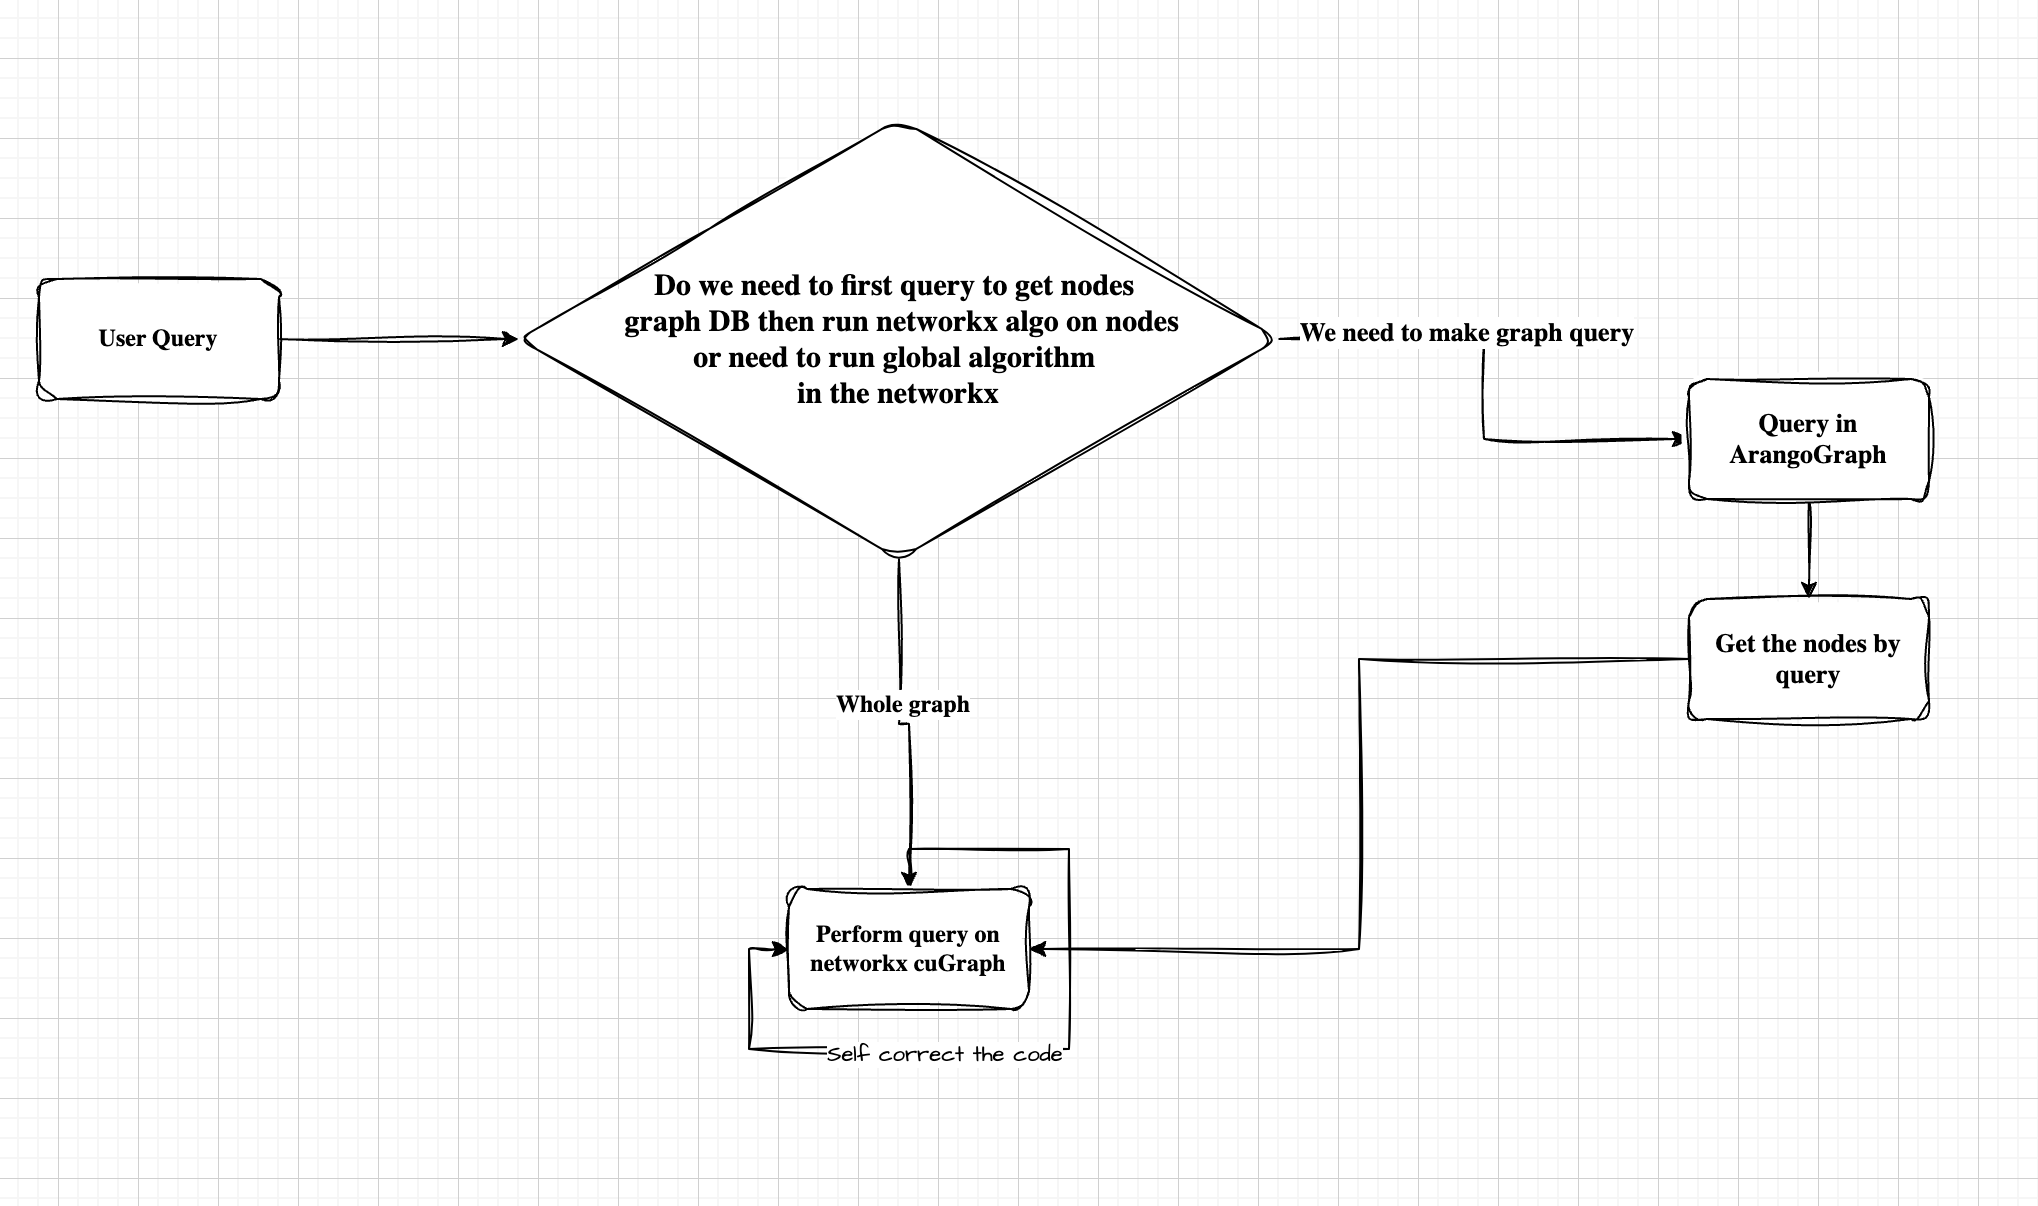

In [ ]:
aql_prompt = PromptTemplate(
  template="""You are an expert in ArangoDB AQL. I will provide a natural language query along with the graph schema for the 'asset' graph. 
  Based on this information, generate a valid AQL query that meets the requirements of the natural language query while referencing the 'asset' graph schema. 
  Return only the final AQL query in your answer. Return the AQL query in code block format starting with ```aql and ending with ```.
  
  Example, Query: Give me all the assets with datasource snowflake
  ```aql
  FOR asset IN asset
    FILTER asset.data_source == 'snowflake'
    SORT asset.score ASC
    RETURN asset
  ```
  
  Important!!! Always return full `asset` documents in the result.
  
  User Query: {query}
  Graph schema: {schema}
  Graph stats: {graph_stats}
  """,
  
  input_variables=["query", "schema", "graph_stats"]
)

aql_generation_chain = LLMChain(
  llm=llm,
  prompt=aql_prompt,
  output_parser=StrOutputParser()
)

In [ ]:
graph_wide_query_prompt = PromptTemplate(
    input_variables=["user_query"],
    template="""
        You are an expert in graph algorithms and Python programming, specifically using the NetworkX library. Graph variable G_adb which is a NetworkX Directed graph, so use only directed graph algorithms.
        **Schema**
        class AssetNode(BaseModel):
        _key: str
        _id: str # The unique identifier of the node from the arangodb graph node
        id: str # The unique identifier of the node, qualifiedname of the asset 
        name: str # The name of the asset
        full_name: str # The full name of the asset
        type: str # data type of the asset i.e INT, STRING, etc
        data_source: str # The data source of the asset i.e Snowflake, Redshift, Kafka, etc
        team: str # The team that owns the asset
        created_at: str # The date the asset was created
        score: int # The score of the asset, we can init it as weight of the node in the graph
        
        result: dict # The result of the algorithm, for example, the pagerank score, etc put it like `score: 0.5`
        @classmethod
        def from_node(cls, node_data):
        return cls(**node_data)
        
        ** Graph Stats **
        {graph_stats}

        **Task:**

        1.  **Algorithm Selection:** Determine the appropriate NetworkX algorithm to execute on an asset graph, based on the user's request. The asset graph is represented by a NetworkX graph object. And each graph ahs attributes that can be used for filtering or sorting with schema AssetNode.
        2.  **Code Generation:** Generate executable Python code that performs the following:
        * Imports the necessary NetworkX library.
        * Assumes the asset graph is already loaded and accessible as a NetworkX graph object named `G_adb`.
        * Executes the selected NetworkX algorithm on `G_adb`.
        * If the user's request implies sorting or filtering the results based on node attributes or relationships, implement the necessary Python code to achieve this.
        * [Important!!!]Also, if the algorith includes any result performed on the nodes, store it in the result attribute of the AssetNode. Like for pagerank score, store it as `score: 0.5`
        * Stores the resulting list of AssetNodes (either the output of the algorithm, or the sorted/filtered list) in a variable named `ASSET_NODES`.
        * Includes all needed imports.
        3.  **Output:** Return the complete, executable Python code snippet. Do not include any explanatory text or comments outside of the code itself. Quote the code snippet in triple backticks (```) to format it as a code block. starts with ```python and ends with ```.

        **Example Scenario:**

        If the user requests "Find me the most important assets in team 5", you would:

        * Select the `networkx.pagerank` algorithm to determine the importance of assets.
        * Generate Python code that calls `networkx.pagerank(G_adb)` and stores the result in `ASSET_NODES`.
        * Filter the `ASSET_NODES` list to include only assets from team 5.
        * Return the complete Python code snippet.
        * To access the dict attributes always use get function to avoid key error.
        
        Example response:
        ```python
        import networkx as nx
        
        nodes = nx.pagerank(G_adb)
        team_5_nodes = [node for node in nodes if node.team == 'team_5']
        
        # sort the nodes based on the score
        team_5_nodes.sort(key=lambda x: x.score, reverse=True)
        
        # set the result attribute of the AssetNode
        for node in team_5_nodes:
            node.result = dict(score=node.get('score', 0))
        
        # Convert the nodes to AssetNode objects
        ASSET_NODES = [AssetNode.from_node(node) for node in team_5_nodes]
        
        ```

        **Constraints:**

        * Assume asset_graph G_adb is already defined.
        * Assume the asset graph nodes have attributes that can be used for filtering or sorting. And attribute score can be used as weight of the node in the graph.
        * Return only executable python code.
        
        **Input:**
        user_query (str): {user_query}
    """
    )

networkx_graph_wide_chain = LLMChain(
    llm=llm,
    prompt=graph_wide_query_prompt,
    output_parser=StrOutputParser()
)

def graph_wide_networkx_algorithms_code(user_query: str) -> str:
    """Run a NetworkX algorithm on an asset graph. Optionally filter or sort the results based on a user query. 
    Return executable Python code that assigns the resulting list of nodes to the variable ASSET_NODES
    Args:
    user_query (str): The user query to determine sorting or filtering criteria.
    
    Returns:
    str: The Python code that when executed will generate a list of AssetNodes.
    """
    
    response = networkx_graph_wide_chain.invoke({"user_query": user_query, "graph_stats": graph_stats})
    result = response if isinstance(response, str) else response.get("text", "")
    

    if not result.strip():
        return "No valid Python code generated."


    print("Generated code:", result.strip())

    return result.strip()

In [ ]:
nx_graph_algorithms_on_list_of_nodes_prompt = PromptTemplate(
    template="""
        You are an expert in graph algorithms and Python programming, specifically using the NetworkX library. Graph variable G_adb which is a NetworkX Directed graph, so use only directed graph algorithms.
        
        **Schema**
        class AssetNode(BaseModel):
        _key: str
        _id: str # The unique identifier of the node from the arangodb graph node
        id: str # The unique identifier of the node, qualifiedname of the asset 
        name: str # The name of the asset
        full_name: str # The full name of the asset
        type: str # data type of the asset i.e INT, STRING, etc
        data_source: str # The data source of the asset i.e Snowflake, Redshift, Kafka, etc
        team: str # The team that owns the asset
        created_at: str # The date the asset was created
        score: int # The score of the asset, we can init it as weight of the node in the graph
        @classmethod
        def from_node(cls, node_data):
        return cls(**node_data)
        
        ** Graph Stats **
        {graph_stats}

        **Task:**

        1.  **Algorithm Selection:** Determine the appropriate NetworkX algorithm to execute on an asset graph, based on the user's request starting from each nodes. The asset graph is represented by a NetworkX graph object. And each graph ahs attributes that can be used for filtering or sorting with schema AssetNode.
        2.  **Code Generation:** Generate executable Python code that performs the following:
        * Imports the necessary NetworkX library.
        * Assumes the asset graph is already loaded and accessible as a NetworkX graph object named `G_adb`.
        * Executes the selected NetworkX algorithm on `G_adb`.
        * If the user's request implies sorting or filtering the results based on node attributes or relationships, implement the necessary Python code to achieve this.
        * Stores the resulting list of AssetNodes (either the output of the algorithm, or the sorted/filtered list) in a variable named `ASSET_NODE_MAP` of type map<node_id, list<AssetNode>>.
        * Includes all needed imports.
        * Also, if the algorithm includes any result performed on the nodes, store it in the result attribute of the AssetNode.
        
        3. These algorithms are basically the algorithms that start from each node and run algorithms starting from each node, returning the result in a map<node_id, list<AssetNode>>.
        4.  **Output:** Return the complete, executable Python code snippet. Do not include any explanatory text or comments outside of the code itself. Quote the code snippet in triple backticks (```) to format it as a code block. starts with ```python and ends with ```.

        **Example Scenario:**

        If the user requests "Find the impacted teams of asset name x", you would:
        1. We would want to find all the impacted nodes from the starting node
        2. Iterate over the list of nodes and find the impacted nodes from each node
        3. Return the impacted nodes in a map<node_id, list<AssetNode>>
        
        Example response:
        ```python
        import networkx as nx
        
        ASSET_NODE_MAP = dict()
        
       
        for node in nodes:
            neighbors = nx.neighbors(G_adb, node.id)
            # Convert the neighbors to AssetNode objects
            ASSET_NODE_MAP[node.id] = [AssetNode.from_node(G_adb.nodes[neighbor]) for neighbor in neighbors]
        ```
        
         One more example:
        
        Find the important assets in the team_5, code example,
        
        ```python
            import networkx as nx
            from collections import defaultdict

            ASSET_NODE_MAP = defaultdict(list)

            # Calculate PageRank for the graph
            pagerank = nx.pagerank(G_adb)

            # Filter nodes by team and sort by PageRank
            for node_id, data in G_adb.nodes(data=True):
                if data['team'] == 'team_5':
                    asset_node = AssetNode.from_node(data)
                    asset_node.result = dict(score=pagerank[node_id])
                    ASSET_NODE_MAP[node_id].append(asset_node)

            # Sort each list of AssetNodes by the result (PageRank score) in descending order
            for node_id in ASSET_NODE_MAP:
                ASSET_NODE_MAP[node_id].sort(key=lambda x: x.result, reverse=True)
        ```
        
        **Constraints:**
        
        - Ensure that the algorithm efficiently handles nodes with a large number of connections.
        - The code should properly handle exceptions and unexpected inputs where applicable.
        - Return only executable python code.
        
        **Input:**
        user_query (str): {user_query}""",
        
    input_variables=["user_query", "graph_stats"]
    )

nx_graph_algorithms_on_list_of_nodes_chain = LLMChain(
    llm=llm,
    prompt=nx_graph_algorithms_on_list_of_nodes_prompt,
    output_parser=StrOutputParser()
)

def nx_graph_algorithms_on_list_of_nodes_code(user_query: str, nodes: list[AssetNode]) -> str:
    """Processes a list of AssetNodes with NetworkX graph algorithms.

    Args:
    user_query (str): The user's natural language query.
    nodes (list[AssetNode]): A list of AssetNode instances to process.
    
    Returns:
    str: A python code snippet that processes the list of AssetNodes with NetworkX graph algorithms.
    """
    response = nx_graph_algorithms_on_list_of_nodes_chain.invoke({"user_query": user_query, "graph_stats": graph_stats})
    
    # Handle both string and dict responses depending on the chain output
    result = response if isinstance(response, str) else response.get("text", "")
    
    if not result:
        raise ValueError("No code generated for the provided user query.")
    
    return result.strip()

In [ ]:
class GraphState(TypedDict):
    user_query: str
    aql_query: str
    networkx_code: str
    asset_nodes: list[AssetNode]
    aql_query: str
    need_graph_query: bool
    need_networx_query: bool
    need_networx_query: bool
    error_message: Optional[str] = None
    retry_count: int = 0

In [ ]:
def decide_from_user_if_need_to_query_arango(state: GraphState) -> GraphState:
    """
    Decide if we need to query ArangoDB first to find the nodes first based on user input before executing networkx code/function from llm
    
    Args:
        state (GraphState): Current state of the graph
    
    Returns:
        GraphState: Updated state of the graph
    """
    user_input = state.get("user_query")
    if not user_input:
        print("User query is empty.")
        return state
    
    # Create prompt template for decision making
    decision_prompt = PromptTemplate(
        template="""You are an expert in graph databases and network analysis. 
        Given a user query about graph analysis, decide if we need to:
        1. First query ArangoDB to find specific starting nodes (return True)
        2. Or directly use NetworkX for graph-wide analysis without specific starting points (return False)

        Consider:
        - Queries about specific nodes or their relationships need ArangoDB first
        - Global graph analysis (like centrality, clustering) can use NetworkX directly
        
        User Query: {query}
        
        Return only True or False:""",
        
        input_variables=["query"]
    )
    
    decision_chain = LLMChain(
        llm=llm,
        prompt=decision_prompt,
        output_parser=StrOutputParser()
    )
    
    decision = decision_chain.run(query=user_input).strip().lower() == 'true'
    
    state["need_graph_query"] = decision
    state["need_networx_query"] = not decision
    
    return state

In [ ]:
def code_correction_agent(code: str, error_message: str, context: str) -> str:
    """
    Agent that corrects Python code based on error messages.
    
    Args:
        code: The Python code that generated an error
        error_message: The error message from the exception
        context: Additional context about what the code was trying to do
    
    Returns:
        Corrected Python code
    """
    correction_prompt = PromptTemplate(
        template="""You are an expert Python programmer. The following Python code has an error:
        
        ```python
        {code}
        ```
        
        The error message is:
        ```
        {error_message}
        ```
        
        Context about what the code should do:
        {context}
        
        Please fix the code to resolve this error. Return ONLY the corrected code block with no explanations.
        Start your response with ```python and end with ```.
        """,
        input_variables=["code", "error_message", "context"]
    )
    
    correction_chain = LLMChain(
        llm=llm,
        prompt=correction_prompt,
        output_parser=StrOutputParser()
    )
    
    response = correction_chain.invoke({
        "code": code,
        "error_message": error_message,
        "context": context
    })
    
    # Extract just the code part
    code_match = re.search(r'```python\s*(.*?)\s*```', response, re.DOTALL)
    if code_match:
        return code_match.group(1)
    return response 
    
def get_aql_from_query(query: str) -> str:
    """Generate AQL from natural language query using the LLM"""
    result = aql_generation_chain.invoke({"query": query, "schema": arango_graph.schema, "graph_stats": graph_stats})
    return result.get("text", "")

def execute_aql_query(aql_query: str) -> List[AssetNode]:
    """Execute AQL query and convert results to AssetNode objects"""
    try:
        # strip the output between ```aql and ```
        aql_query = re.search(r'```aql(.*?)```', aql_query, re.DOTALL)
        if aql_query:
            aql_query = aql_query.group(1).strip()
        else:
            print("AQL query not found.")
            return None
        results = db.aql.execute(aql_query)
        nodes = []
        for result in results:
            if isinstance(result, dict):
                try:
                    print(result)
                    print("\n")
                    nodes.append(AssetNode(**result))
                except Exception as e:
                    print(f"Error converting to AssetNode: {str(e)}")
        return nodes
    except Exception as e:
        print(f"Error executing AQL query: {str(e)}")
        return []

def decide_from_user_if_need_to_query_arango(state: GraphState) -> GraphState:
    """Determine if we should use NetworkX directly or query ArangoDB first using LLM"""
    query = state.get("user_query", "")
    
    prompt = PromptTemplate(
        template="""Given this user query: {query}
        Decide if we should:
        1. Use NetworkX directly for graph-wide analysis (for queries about network structure, paths, centrality, clusters)
        2. Query ArangoDB first to get specific nodes (for queries about specific properties, filtering, or finding particular nodes)
        
        Return only 'networkx' or 'arangodb' as your answer.""",
        input_variables=["query"]
    )
    
    chain = LLMChain(llm=llm, prompt=prompt)
    result = chain.invoke({"query": query})
    decision = result.get("text", "").strip().lower()
    
    state["need_networx_query"] = decision == "networkx"
    state["need_graph_query"] = decision == "arangodb"
    return state

def run_graph_wide_networkx(state: GraphState) -> GraphState:
    """Generate and execute NetworkX code for graph-wide analysis"""
    if not state.get("retry_count"):
        state["retry_count"] = 1
    
    if state["retry_count"] > 3:
        return state
    
    state["retry_count"] += 1
    if state.get("error_message"):
        state["networkx_code"] = code_correction_agent(state["networkx_code"], state["error_message"], state["user_query"])
    else:
        networkx_code = graph_wide_networkx_algorithms_code(state["user_query"])
    state["networkx_code"] = networkx_code

    code_match = re.search(r'```python\s*(.*?)\s*```', networkx_code, re.DOTALL)
    if code_match:
        try:
            code = code_match.group(1)
            locals_dict = {"G_adb": G_adb, "nx": nx, "AssetNode": AssetNode}
            exec(code, globals(), locals_dict)
            if "ASSET_NODES" in locals_dict:
                state["asset_nodes"] = locals_dict["ASSET_NODES"]
                state["error_message"] = None
        except Exception as e:
            state["error_message"] = str(e)
            print(f"Error executing NetworkX code: {str(e)}")
    
    return state

def generate_aql_query(state: GraphState) -> GraphState:
    """Generate AQL query from user query"""
    aql_query = get_aql_from_query(state["user_query"])
    state["aql_query"] = aql_query
    return state

def execute_query_and_get_nodes(state: GraphState) -> GraphState:
    """Execute AQL query and get nodes"""
    aql_query = state["aql_query"]
    nodes = execute_aql_query(aql_query)
    state["asset_nodes"] = nodes
    return state

def run_networkx_on_nodes(state: GraphState) -> GraphState:
    """Run NetworkX algorithms on the nodes retrieved from ArangoDB"""
    nodes = state["asset_nodes"]
    if not nodes:
        return state
    
    if not state.get("retry_count"):
        state["retry_count"] = 1
    
    if state["retry_count"] > 3:
        return state
    
    state["retry_count"] += 1
    if state.get("error_message"):
        state["networkx_code"] = code_correction_agent(state["networkx_code"], state["error_message"], state["user_query"])
    else:
        networkx_code = nx_graph_algorithms_on_list_of_nodes_code(state["user_query"], nodes)
        state["networkx_code"] = networkx_code

    code_match = re.search(r'```python\s*(.*?)\s*```', networkx_code, re.DOTALL)
    if code_match:
        try:
            code = code_match.group(1)
            locals_dict = {"G_adb": G_adb, "nx": nx, "nodes": nodes, "AssetNode": AssetNode}
            exec(code, globals(), locals_dict)
            # Update with results if available
            if "ASSET_NODE_MAP" in locals_dict:
                # Convert to list for consistency
                node_map = locals_dict["ASSET_NODE_MAP"]
                all_nodes = []
                for node_list in node_map.values():
                    all_nodes.extend(node_list)
                state["asset_nodes"] = all_nodes
                state["error_message"] = None
        except Exception as e:
            print(f"Error executing NetworkX code on nodes: {str(e)}")
            state["error_message"] = str(e)
    
    return state



In [ ]:
# Build the graph
builder = StateGraph(GraphState)

# Add nodes to the graph
builder.add_node("decide_from_user_if_need_to_query_arango", decide_from_user_if_need_to_query_arango)
builder.add_node("run_graph_wide_networkx", run_graph_wide_networkx)
builder.add_node("generate_aql_query", generate_aql_query)
builder.add_node("execute_query_and_get_nodes", execute_query_and_get_nodes)
builder.add_node("run_networkx_on_nodes", run_networkx_on_nodes)

builder.add_edge(START, "decide_from_user_if_need_to_query_arango")

builder.add_conditional_edges(
    "decide_from_user_if_need_to_query_arango",
    lambda state: "run_graph_wide_networkx" if state["need_networx_query"] else "generate_aql_query"
)

builder.add_edge("generate_aql_query", "execute_query_and_get_nodes")
builder.add_edge("execute_query_and_get_nodes", "run_networkx_on_nodes")

# Compile the graph
graph = builder.compile()

In [ ]:
from IPython.display import Image, display
display(Image(graph.get_graph().draw_mermaid_png()))

In [ ]:
def list_of_nodes_to_dataframe(nodes: List[AssetNode]) -> pd.DataFrame:
    """Convert a list of AssetNode instances to a pandas DataFrame"""
    
    # Create a list of dictionaries from the nodes
    node_dicts = []
    for node in nodes:
        node_dict = {
            'Qualified Name': node.id,
            'Name': node.name,
            'Full name': node.full_name,
            'Asset type': node.type,
            'Data Source': node.data_source,
            'Team': node.team,
            'Created At': node.created_at,
            'Score': node.score
        }
        
        if hasattr(node, 'result') and node.result:
            for key, value in node.result.items():
                node_dict[f'result_{key}'] = str(value)
                
        node_dicts.append(node_dict)
    
    df = pd.DataFrame(node_dicts)
    
    return df

### Now we will create a gradio interface to interact with the graph and perform the analysis

In [ ]:

def list_of_nodes_to_dataframe(nodes):
    """Convert a list of AssetNode objects to a pandas DataFrame."""
    if not nodes:
        return pd.DataFrame()
    
    # Extract node attributes
    node_data = []
    for node in nodes:
        node_dict = {k: v for k, v in node.__dict__.items() if not k.startswith('_')}
        
        if hasattr(node, 'result') and isinstance(node.result, dict):
            for key, value in node.result.items():
                if key != 'score':
                    node_dict[f'result_{key}'] = value
        
        node_data.append(node_dict)
    
    df = pd.DataFrame(node_data)

    priority_cols = ['name', 'team', 'data_source', 'type']
    result_cols = [col for col in df.columns if col.startswith('result_')]
    other_cols = [col for col in df.columns if col not in priority_cols and col not in result_cols]
    
    df = df[priority_cols + result_cols + other_cols]
    return df

def advanced_node_insight(query_text):
    local_state = GraphState(user_query=query_text)
    concluded_state = graph.invoke(local_state)
    final_nodes = concluded_state.get('asset_nodes', [])
    result_df = list_of_nodes_to_dataframe(final_nodes)
    
    fig = None
    if not result_df.empty and len(result_df) > 1:
        score_cols = [col for col in result_df.columns if col.startswith('result_')]
        if score_cols:
            fig = px.bar(result_df.head(20), 
                         x='Name', 
                         y=score_cols[0], 
                         color='Team',
                         title=f'Top 20 Assets by {score_cols[0]}')
            fig.update_layout(
                template="plotly_white",
                xaxis_title="Asset Name",
                yaxis_title=score_cols[0].replace('_', ' ').title(),
                legend_title="Team"
            )
    
    return (
        result_df.head(50),
        f"Returned {len(final_nodes)} assets",
        fig if fig else None
    )

# Enhanced CSS for better styling
css = """
.gradio-container {
    font-family: 'Roboto', sans-serif;
}
.app-title {
    font-size: 2.5rem;
    color: #2F2F2F;
    text-align: center;
    padding: 1rem;
    background: linear-gradient(to right, #FFF8E1, #E1F7FA);
    border-radius: 10px;
    margin-bottom: 1.5rem;
    box-shadow: 0 4px 6px rgba(0, 0, 0, 0.1);
}
.tabs {
    margin-top: 2rem;
}

/* Enhanced table styling */
.table-container {
    max-height: 600px;
    overflow-y: auto;
    margin-bottom: 1rem;
    border-radius: 8px;
    box-shadow: 0 2px 10px rgba(0, 0, 0, 0.1);
}

.table-container table {
    border-collapse: separate;
    border-spacing: 0;
    width: 100%;
}

.table-container th {
    background-color: #f0f7fa;
    color: #2c3e50;
    font-weight: 600;
    text-transform: uppercase;
    font-size: 0.9rem;
    padding: 12px !important;
    position: sticky;
    top: 0;
    z-index: 10;
    border-bottom: 2px solid #e3f2fd;
}

.table-container td {
    padding: 10px !important;
    border-bottom: 1px solid #ecf0f1;
}

.table-container tr:nth-child(even) {
    background-color: #fe5;
    color: #000;
}

.table-container tr:hover {
    background-color: #9999;
    transition: background-color 0.2s ease;
    color: #000; /* Ensuring text remains visible on hover */
}

.filter-active {
    background-color: #e3f2fd !important;
    color: #000; /* Ensuring text remains visible when filter is active */
}
"""

with gr.Blocks(css=css, theme=gr.themes.Soft()) as lineage_impact_demo_ui:
    gr.Markdown("<div class='app-title'>LineageImpact Interactive UI</div>")
    
    with gr.Row():
        with gr.Column(scale=3):
            user_input = gr.Textbox(
                label='Enter your graph-related query',
                placeholder="Example: Find the most important assets in team_5",
                lines=3
            )
        with gr.Column(scale=1):
            run_btn = gr.Button('Process Query', variant='primary', scale=2)
            clear_btn = gr.Button('Clear', variant='secondary')
    
    summary_info = gr.Textbox(label='Summary', interactive=False)
    
    with gr.Tabs(elem_classes="tabs") as tabs:
        with gr.TabItem("Table View"):
            # Add search filter above the scrollable table container
            search_filter = gr.Textbox(label="Search/Filter Table", placeholder="Type to filter data...")
   
            with gr.Column(elem_classes="table-container"):
                output_table = gr.DataFrame(
                    interactive=True,
                    wrap=True,
                    column_widths=["auto"]*5, 
                    datatype=None,
                )
            
            with gr.Row():
                table_pagination = gr.Slider(minimum=10, maximum=50, step=10, value=20, 
                                          label="Rows per page", interactive=True)
                export_btn = gr.Button("Export to CSV", variant="secondary")
        
        with gr.TabItem("Visualization"):
            plot_output = gr.Plot(label="Data Visualization")
    
    with gr.Accordion("Example Queries", open=False):
        examples = gr.Examples(
            examples=[
                ["Find the most important assets in team_5"],
                ["Want to reduce spending on assets, find me the disconnected assets"],
                ["Which assets have the highest connectivity?"],
                ["What is the most used data source in the graph?"],
                ["Tell me least used snowflake assets"]
            ],
            inputs=user_input
        )
    
    def handle_query(input_text):
        if not input_text.strip():
            return None, "Please enter a query", None
        
        try:
            df, summary, plot = advanced_node_insight(input_text)
            return df, summary, plot
        except Exception as e:
            return None, f"Error: {str(e)}", None
    
    def clear_inputs():
        return "", "", None, None
    
    def export_table_to_csv(table_data):
        if table_data is not None and not isinstance(table_data, str):
            temp_df = pd.DataFrame(table_data)
            csv_path = "exported_data.csv"
            temp_df.to_csv(csv_path, index=False)
            return f"Data exported to {csv_path}"
        return "No data to export"
    
    def filter_table(filter_text, current_table):
        if not filter_text or current_table is None:
            return current_table
        
        df = pd.DataFrame(current_table)
        mask = pd.Series(False, index=df.index)
        
        for col in df.columns:
            mask |= df[col].astype(str).str.contains(filter_text, case=False, na=False)
        
        filtered_df = df[mask]
        return filtered_df
    
    run_btn.click(fn=handle_query, inputs=[user_input], outputs=[output_table, summary_info, plot_output])
    clear_btn.click(fn=clear_inputs, inputs=[], outputs=[user_input, summary_info, output_table, plot_output])
    export_btn.click(fn=export_table_to_csv, inputs=[output_table], outputs=[gr.Textbox(label="Export Status")])
    search_filter.change(fn=filter_table, inputs=[search_filter, output_table], outputs=[output_table])
    
    table_pagination.change(
        lambda rows, table: table.iloc[:rows], 
        inputs=[table_pagination, output_table], 
        outputs=[output_table]
    )
    
    gr.Markdown("""
        <div style='text-align:center; margin-top:20px; padding:10px; background:#f5f5f5; border-radius:5px;'>
            <p>Explore your graph data with natural language queries!</p>
            <p style='font-size:0.8rem; color:#666;'>Powered by LLMs and Graph Analytics</p>
        </div>
    """)

lineage_impact_demo_ui.launch(inline=False, debug=True, share=False)